# 主成分分析の結果を用いた分類

- 主成分分析の結果（主成分）を用いて分類
- 次元削減が可能かどうかAUCを比較

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

iris = sns.load_dataset('iris')

# 2値データへの分類のため、species から setosa を除外
# speciesを 0, 1 にするためにダミー変数化
iris_dummies = pd.get_dummies(data=iris.query('species!="setosa"'), drop_first=True)
# 確認
iris_dummies.iloc[[0, 50]]

,sepal_length,sepal_width,petal_length,petal_width,species_virginica
50,7.0,3.2,4.7,1.4,0
100,6.3,3.3,6.0,2.5,1


In [2]:
# 説明変数：species_virginica 列を削除
X = iris_dummies.drop(['species_virginica'], axis=1)

# 標準化
# - 主成分分析では分散（平均値からのばらつき）を用いるため
#   標準化により平均値を 0 に揃える
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)

# 標準化した DataFrame
X_std = pd.DataFrame(sc.transform(X), index=X.index, columns=X.columns)

### 全ての主成分の説明率

In [3]:
from sklearn.decomposition import PCA

# 主成分分析 PCA の初期化
# - n_components=None: 主成分はもとの説明変数と同数
pca = PCA(n_components=None)

# 学習結果を DataFrame
X_transformed = pd.DataFrame(pca.fit_transform(X_std))

# 結果
# - explained_variance_ratio_: 各主成分が元のデータを説明する割合
print('各次元の説明率: {}'.format(pca.explained_variance_ratio_))
print('累積説明率: {:.3f}'.format(sum(pca.explained_variance_ratio_)))

各次元の説明率: [0.7394778  0.13877791 0.10143342 0.02031087]
累積説明率: 1.000


setosaを除外したことで、3値の時とは若干異なる結果になっている。

### ロジスティック回帰による分類

- 主成分の数を変えて分類

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

def Logistic_Model(X, Y):
    """
    ロジスティック回帰モデルを作成
    """
    model = LogisticRegression(C=10000.0, max_iter=10000000)
    model.fit(X, Y)
    return model

def calc_AUC(model, X, Y):
    """
    AUCの算出
    """
    Y_proba = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
    return auc(fpr, tpr)

- 主成分による分類

In [5]:
# 目的変数：species_virginica 列　
Y = iris_dummies['species_virginica']

for n in range(1, 5):
    X_df = X_transformed.iloc[:, 0:n]
    Y.index = X_df.index
    model = Logistic_Model(X_df, Y)
    AUC = calc_AUC(model, X_df, Y)
    print('n={}: AUC={:.3f}'.format(n, AUC))

n=1: AUC=0.929
n=2: AUC=0.975
n=3: AUC=0.997
n=4: AUC=0.997


- もとのデータによる分類

In [6]:
model = Logistic_Model(X, Y)
AUC = calc_AUC(model, X, Y)
print('AUC={:.3f}'.format(AUC))

AUC=0.997


主成分3つで、もとのデータと同じAUCで分類可能
- 各次元の説明率
  - 3つの主成分の合計が1に近い値
  - 4つ目の主成分の説明率は小さい

### 主成分による決定境界

- 主成分2つの場合の決定境界

In [7]:
# 決定境界の描画（第7回で説明）
import numpy as np

def plot_decision_boundary(model, X, y):
    """
    決定境界の描画関数
    """
    # 1, 2列目の取得
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]

    # 散布図の描画
    sns.scatterplot(x=x1, y=x2, hue=y)

    # 刻み幅の指定
    step = 0.01
    # 描画範囲の拡大幅
    a = 0.5
    # 格子座標の作成
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1.min() - a, x1.max() + a, step),
                                   np.arange(x2.min() - a, x2.max() + a, step))
    # 格子の座標に対する予測値を計算
    Z = model.predict(pd.DataFrame(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T,
                                   columns=X.columns))
    # contourf: 領域の塗りつぶし
    # - alpha: 透過度
    # - cmap: https://matplotlib.org/stable/tutorials/colors/colormaps.html に記載
    plt.contourf(x1_mesh, x2_mesh, Z.reshape(x1_mesh.shape), alpha=0.3, cmap='coolwarm')
    plt.show()

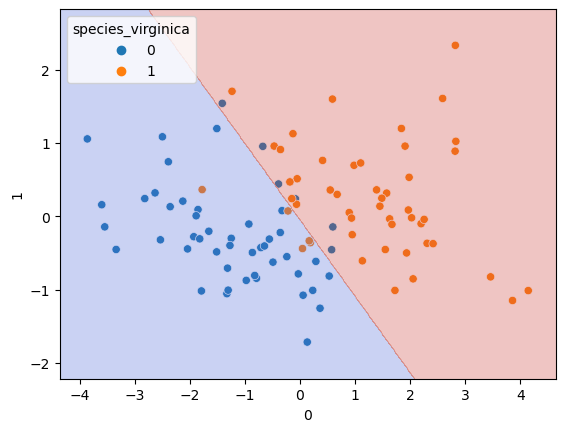

In [8]:
# 主成分は2つ
X_df = X_transformed.iloc[:, 0:2]
Y.index = X_df.index

# モデルの作成
model = Logistic_Model(X_df, Y)

# 決定境界の描画
plot_decision_boundary(model, X_df, Y)